In [ ]:
# Remove old environment variables (if set)
import os
os.environ.pop("SPARK_HOME", None)
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


In [ ]:
!apt-get install -y openjdk-11-jdk
!pip install -q pyspark xgboost h5py seaborn


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [ ]:
!apt-get install -y openjdk-11-jdk
!pip install -q pyspark xgboost h5py seaborn


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-11-jdk is already the newest version (11.0.28+6-1ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("USPS_XGBoost_PySpark") \
    .master("local[*]") \
    .getOrCreate()

print("✅ Spark session started:", spark.version)


✅ Spark session started: 3.5.1


✅ Spark session started: 3.5.1


Saving usps.h5 to usps.h5
Uploaded file: usps.h5
Combined dataset shape: (9298, 256) (9298,)


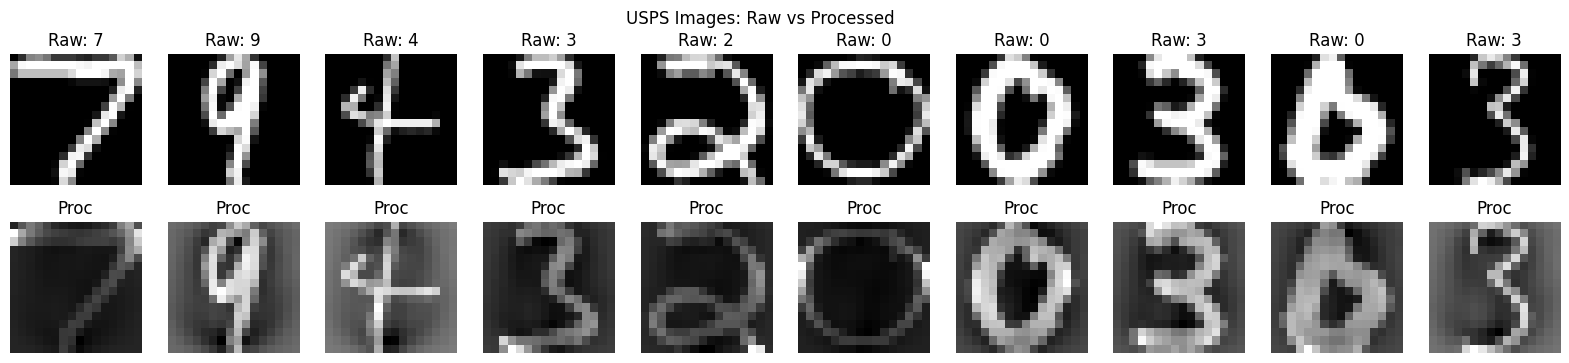

Train shape: (800, 256) (800,)
Test shape: (200, 256) (200,)
✅ Spark DataFrames created
+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.0818867608904...|
|    9|[-0.0818867608904...|
|    5|[-0.0818867608904...|
|    8|[-0.0818867608904...|
|    6|[-0.0818867608904...|
+-----+--------------------+
only showing top 5 rows



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:01:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Classification Accuracy: 90.50%


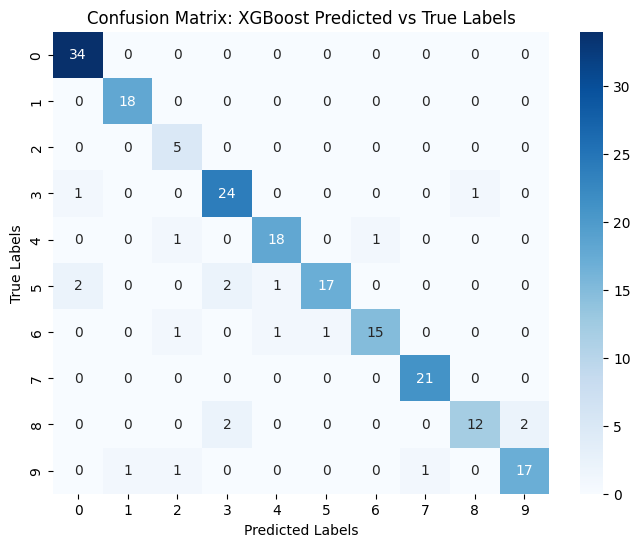

✅ Raw sample saved as 'usps_sample_raw.npz'
✅ Processed sample saved as 'usps_sample_processed_xgb.npz'
First 20 predicted labels: [9 8 3 7 7 4 5 7 2 4 6 3 7 1 7 6 9 3 3 9]
First 20 true labels:      [9 8 3 7 7 5 5 7 2 6 4 3 7 1 7 6 9 3 5 9]


In [ ]:

# -----------------------------
# 3️⃣ Imports
# -----------------------------
import h5py, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import files
import xgboost as xgb
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

# -----------------------------
# 4️⃣ Start PySpark Session
# -----------------------------
spark = SparkSession.builder \
    .appName("USPS_XGBoost_PySpark") \
    .master("local[*]") \
    .getOrCreate()
print("✅ Spark session started:", spark.version)

# -----------------------------
# 5️⃣ Upload USPS .h5
# -----------------------------
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)

# -----------------------------
# 6️⃣ Load USPS data
# -----------------------------
with h5py.File(filename, 'r') as f:
    images_train = np.array(f['train']['data'])
    labels_train = np.array(f['train']['target']).flatten()
    images_test = np.array(f['test']['data'])
    labels_test = np.array(f['test']['target']).flatten()

images_all = np.concatenate((images_train, images_test), axis=0)
labels_all = np.concatenate((labels_train, labels_test), axis=0)
print("Combined dataset shape:", images_all.shape, labels_all.shape)

# -----------------------------
# 7️⃣ Sample 1000 images
# -----------------------------
np.random.seed(42)
sample_indices = np.random.choice(len(images_all), 1000, replace=False)
images_sample = images_all[sample_indices]
labels_sample = labels_all[sample_indices]

# -----------------------------
# 8️⃣ Preprocessing (normalize + standardize)
# -----------------------------
images_sample_norm = images_sample / 255.0
scaler = StandardScaler()
images_sample_scaled = scaler.fit_transform(images_sample_norm)

# -----------------------------
# 9️⃣ Visualize raw vs processed
# -----------------------------
num_samples = 10
plt.figure(figsize=(20,4))
for i in range(num_samples):
    plt.subplot(2, num_samples, i+1)
    plt.imshow(images_sample[i].reshape(16,16), cmap='gray')
    plt.title(f"Raw: {labels_sample[i]}")
    plt.axis('off')

    plt.subplot(2, num_samples, i+1+num_samples)
    img_proc_vis = (images_sample_scaled[i] - images_sample_scaled[i].min()) / np.ptp(images_sample_scaled[i])
    plt.imshow(img_proc_vis.reshape(16,16), cmap='gray')
    plt.title("Proc")
    plt.axis('off')
plt.suptitle("USPS Images: Raw vs Processed")
plt.show()

# -----------------------------
# 🔟 Split into train/test
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    images_sample_scaled, labels_sample, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# -----------------------------
# 1️⃣1️⃣ Convert to PySpark DataFrame (optional)
# -----------------------------
train_rows = [Row(label=int(y), features=Vectors.dense(x)) for x, y in zip(X_train, y_train)]
test_rows = [Row(label=int(y), features=Vectors.dense(x)) for x, y in zip(X_test, y_test)]
train_df = spark.createDataFrame(train_rows)
test_df = spark.createDataFrame(test_rows)
print("✅ Spark DataFrames created")
train_df.show(5)

# -----------------------------
# 1️⃣2️⃣ Train XGBoost Classifier
# -----------------------------
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=10,
    max_depth=6,
    n_estimators=200,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# -----------------------------
# 1️⃣3️⃣ Predict & Evaluate
# -----------------------------
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ XGBoost Classification Accuracy: {acc*100:.2f}%")

cm = confusion_matrix(y_test, y_pred, labels=np.arange(10))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: XGBoost Predicted vs True Labels")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# -----------------------------
# 1️⃣4️⃣ Save datasets
# -----------------------------
np.savez("usps_sample_raw.npz", images=images_sample, labels=labels_sample)
np.savez("usps_sample_processed_xgb.npz", images=images_sample_scaled, labels=y_pred)
print("✅ Raw sample saved as 'usps_sample_raw.npz'")
print("✅ Processed sample saved as 'usps_sample_processed_xgb.npz'")

# -----------------------------
# 1️⃣5️⃣ Show first 20 predictions
# -----------------------------
print("First 20 predicted labels:", y_pred[:20])
print("First 20 true labels:     ", y_test[:20])